In [15]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river.datasets import synth
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from river import drift
from river import datasets
from sklearn.metrics import accuracy_score

In [16]:
# Function to return samples with a rolling average mean window
def moving_average(datastream, window_size):

    datastream_series = pd.Series(datastream)
    windows = datastream_series.rolling(window_size)
    moving_averages = windows.mean()

    return moving_averages.tolist()[window_size - 1:]

#### River

In [17]:
# Create mini-batch of features and labels
from sklearn.metrics import accuracy_score

labels = list()
features = list()
predictions = list()
def create_mini_batch(feature, label, prediction, batch_size=100):

    labels.append(label)
    features.append(feature)
    predictions.append(int(prediction))
    
    label_window = pd.Series(labels)[-batch_size:]
    feature_window = pd.DataFrame(features)[-batch_size:]
    pred_window = pd.Series(predictions)[-batch_size:]
    
    accuracy = accuracy_score(label_window, pred_window)
    
    return feature_window, label_window, accuracy

In [18]:
# Load dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load pickled model
model_1 = pickle.load(open('/home/jaydeep/book_ML_drifts/chapter_5/saved_models/river_model.pkl', 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# List to store accuracy 
accuracy_buffer_1 = list()

# batch size
batch_size = 100

for i,data in enumerate(dataset.take(10000),1):
    # data[0] - features, data[1] - label
    y_pred = model_1.predict_one(data[0])
    metric = metric.update(data[1],y_pred)
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred,batch_size)
    # Update model with feature and label buffers
    if i%batch_size==0:
        accuracy_buffer_1.append(accuracy)
        model_1.learn_many(feature_buffer,label_buffer)

print(metric)

Accuracy: 61.12%


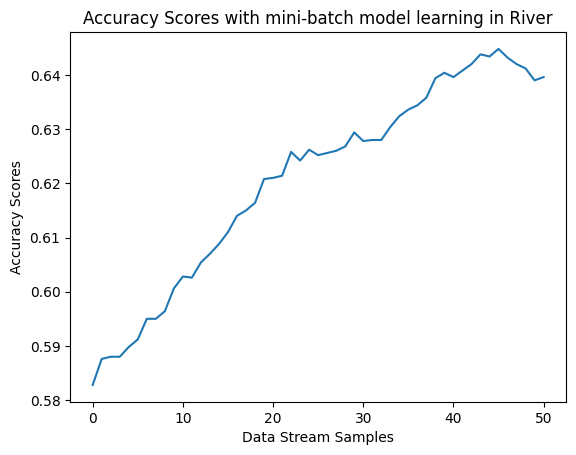

In [19]:
# Calculating moving average for accuracy score to remove noise
acc_scores_1_moving_avg = moving_average(accuracy_buffer_1,50)
def plot():
    plt.plot(acc_scores_1_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with mini-batch model learning in River')
    plt.show()
plot()

#### Scikit-learn

In [20]:
# Load dataset
dataset = synth.Agrawal(
     classification_function=0,
     seed=42
)

# Load pickled model
sklrn_clf = pickle.load(open("/home/jaydeep/book_ML_drifts/chapter_5/saved_models/sklrn_model.pkl", 'rb'))

# Initialise metric
metric = metrics.Accuracy()

# List to store accuracy
accuracy_buffer_2 = list()

# batch size
batch_size = 100

for i,data in enumerate(dataset.take(10000),1):
    # data[0] - features, data[1] - label
    y_pred = sklrn_clf.predict(np.reshape(list(data[0].values()), (-1, 1)).T)
    metric = metric.update(data[1],y_pred[0])
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred[0],batch_size)
    # Update model with feature and label buffers
    if i%batch_size==0:
        accuracy_buffer_2.append(accuracy)
        sklrn_clf.partial_fit(feature_buffer.to_numpy(),label_buffer.ravel())

print(metric)

Accuracy: 51.13%


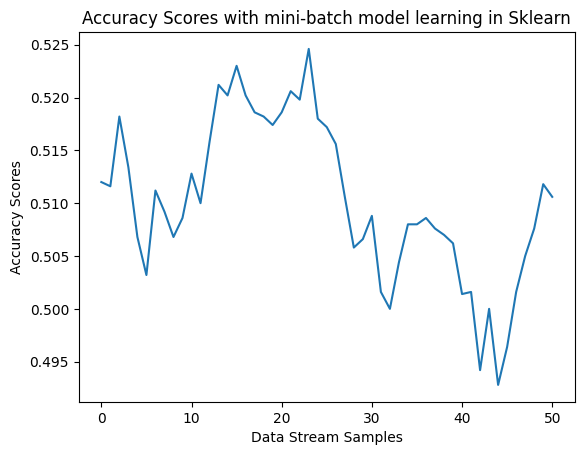

In [21]:
# Calculating moving average for accuracy score to remove noise
acc_scores_2_moving_avg = moving_average(accuracy_buffer_2,50)
def plot():
    plt.plot(acc_scores_2_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with mini-batch model learning in Sklearn')
    plt.show()
plot()

#### PyTorch

In [22]:
import torch
from torch.optim import SGD
from torch.nn import BCELoss
from torch import nn
from torch import optim
from torch import manual_seed

In [23]:
_ = manual_seed(42)

In [24]:
class MyModule(nn.Module):
    def __init__(self, n_features):
        super(MyModule, self).__init__()
        self.dense0 = nn.Linear(n_features, 5)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(5, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.nonlin(self.dense1(X))
        X = self.softmax(X)
        return X

In [25]:
# train the model
def train_model(train_data, model):
    predictions, actuals = list(), list()
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, label) in enumerate(train_data):
            # data[0] - features, data[1] - label
            X = torch.tensor(list(inputs.values()), dtype=torch.float).clone().detach().requires_grad_(True)
            y = torch.tensor(label, dtype=torch.float).clone().detach().requires_grad_(True)
            y = torch.reshape(y, (-1,))
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            y_pred = model(X)
            # calculate loss
            loss = criterion(y_pred, y)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        
            # round to class values
            y_pred = y_pred.round()
            # store
            predictions.append(y_pred.detach().numpy())
            actuals.append(y.detach().numpy())
    # calculate overall accuracy
    acc = accuracy_score(actuals, predictions)
    print(f"Accuracy: {acc}")

In [26]:
# Learn many samples using Pytorch model
def learn_many(input_data, label_data, model):
    # define the optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(1):
        # enumerate mini batches
        for data in zip(input_data, label_data):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            y_pred = model(X)
            # calculate loss
            loss = criterion(y_pred, y)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [27]:
# Create mini-batch of features and labels
labels, features, predictions = list(), list(), list()
def create_mini_batch(feature, label, prediction, batch_size=100):

    labels.append(label)
    features.append(list(feature.values()))
    predictions.append(int(prediction))
    
    label_window = labels[-batch_size:]
    feature_window = features[-batch_size:]
    pred_window = predictions[-batch_size:]
    
    accuracy = accuracy_score(label_window, pred_window)
    
    return feature_window, label_window, accuracy

In [28]:
# Load dataset
dataset = datasets.Phishing()

# Load model
pyt_model = pickle.load(open("/home/jaydeep/book_ML_drifts/chapter_5/saved_models/pyt_model.pkl", 'rb'))

predictions, actuals = list(), list()
accuracy_scores_list = list()

# batch size
batch_size = 10

for i,data in enumerate(dataset.take(16000),1):
    # data[0] - features, data[1] - label
    X = torch.tensor(list(data[0].values()), dtype=torch.float).clone().detach().requires_grad_(True)
    y = torch.tensor(data[1], dtype=torch.float).clone().detach().requires_grad_(True)
    y = torch.reshape(y, (-1,))
    
    y_pred = pyt_model(X)
    feature_buffer,label_buffer, accuracy = create_mini_batch(data[0],data[1],y_pred,batch_size)
    
    if i%batch_size==0:
        feature_buffer_tensor = torch.tensor(feature_buffer, dtype=torch.float).clone().detach().requires_grad_(True)
        label_buffer_tensor = torch.tensor(label_buffer, dtype=torch.float).clone().detach().requires_grad_(True)
        label_buffer_reshaped = torch.reshape(label_buffer_tensor, (-1,1))
        
        learn_many(feature_buffer_tensor,label_buffer_reshaped, pyt_model)
        accuracy_scores_list.append(accuracy)

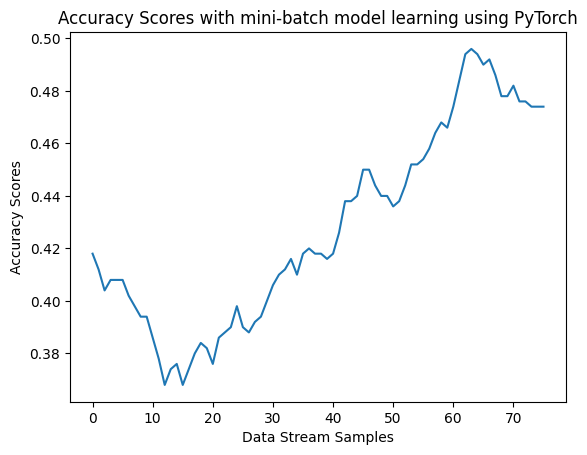

In [29]:
# Plot accuracy scores
def plot():
    acc_scores_moving_avg = moving_average(accuracy_scores_list,50)
    plt.plot(acc_scores_moving_avg)
    plt.xlabel('Data Stream Samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Accuracy Scores with mini-batch model learning using PyTorch')
    plt.show()
plot()